In [6]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


In [62]:
import chainer
from chainer import cuda
from chainercv.links.model.faster_rcnn import FasterRCNNVGG16

from chainercv.utils import bbox_iou
import numpy as np
import cupy as cp
import random

In [33]:
from imageio import imread
import pandas as pd

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
model = FasterRCNNVGG16(20, 'voc07')

In [22]:
model.to_gpu()

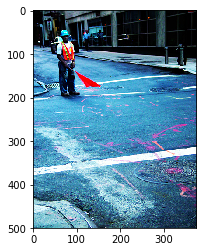

In [41]:
img = imread('data/flickr30k-images/100652400.jpg')
plt.imshow(img)

In [42]:
prepared_img = model.prepare(img.transpose(2, 0, 1))
prepared_img = cuda.to_gpu(prepared_img[None])
with chainer.using_config('train', False), chainer.function.no_backprop_mode():
    roi_cls_locs, roi_scores, rois, _ = model(prepared_img, scale=1.)

In [56]:
data = pd.read_csv('data/gt-roi/phrase_pair_val.csv')
roi1 = data.roi1.values[0]
roi2 = data.roi2.values[0]

In [57]:
roi1 = cp.asarray(list(map(int, roi1[1:-1].split(','))))
roi2 = cp.asarray(list(map(int, roi2[1:-1].split(','))))

In [ ]:
ious = bbox_iou(rois, cp.vstack((roi1, roi2)))
ious > .5

In [ ]:
from chainer import dataset
from chainercv.utils import bbox_iou
import cupy as cp

class Dataset(dataset.DatasetMixin):
    def __init__(self, split, localization_acc=0.7):
        self.frcnn = FasterRCNNVGG16(20, 'voc07')
        self.loc_ratio = localization_acc
        self.data = pd.read_csv('data/gt-roi/phrase_pair_%s.'%split)
    
    def sample_region(self, img, gtroi_1, gtroi_2):
        prep_img = model.prepare(img.transpose(2, 0, 1))
        prep_img = cuda.to_gpu(prep_img[None])
        
        with chainer.using_config('train', False), chainer.function.no_backprop_mode():
            roi_cls_locs, roi_scores, rois, _ = model(prep_img, scale=1.)
              
        ious = bbox_iou(rois, cp.vstack((gtroi_1, gtroi_2)))
        
        bboxes = []
        
        for i in range(2):
            correct_bbox_indices = np.where(ious[:, i].ravel() >= .5)
            incorrect_bbox_indices = np.where(ious[:, i].ravel() < .5)
            
            if random.random() < self.loc_ratio:
                bbox_index = random.choice(correct_bbox_indices) # sample from correct bbox
            else:
                bbox_index = random.choice(incorrect_bbox_indices) # sample from incorrect bbox
        
            bboxes.append(rois[bbox_index])
        
        return bboxes[0], bboxes[1]
        
    
    def get_example(self, i):
        return  phrase_1, phrase_2, rfeat_1, rfeat_2, roi_1, roi_2, label